In [1]:
# Re-implmentation of AI Clinician Matlab Code in Python 
# Author: KyungJoong Kim (GIST, South Korea)
# Date: 2020 June 2 
# 
# This code is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY;
# without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE

# Note 
# 
# python interp1d() and matlab interp1() are very close each other but not the same 
# => possible difference at 15 digits or more after the decimal point 
# => usually, it doesn't make any change on the outcomes but has small impact on sorting function and equal operator (=) 
#


# AI Clinician Building MIMIC-III dataset 

# (c) Matthieu Komorowski, Imperial College London 2015-2019
# as seen in publication: https://www.nature.com/articles/s41591-018-0213-5

# version 16 Feb 19
# uses the sepsis-3 cohort previously defined
# builds the MIMIC-III dataset

# This code is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY;
# without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE

import pickle 
import numpy as np 
import pandas as pd 
import scipy.io as sio 
import matplotlib 
import matplotlib.pyplot as plt
from scipy.stats.mstats import mquantiles
from scipy.interpolate import interp1d 
from scipy.spatial.distance import pdist, squareform

# To ignore 'Runtime Warning: Invalid value encountered in greater' caused by NaN 
np.warnings.filterwarnings('ignore')

# Load pickle for step 3 
with open('step_3_start.pkl', 'rb') as file:
    sample_and_hold = pickle.load(file)
    demog= pickle.load(file)
    ce010= pickle.load(file)
    ce1020= pickle.load(file)
    ce2030= pickle.load(file)
    ce3040= pickle.load(file)
    ce4050= pickle.load(file)
    ce5060= pickle.load(file)
    ce6070= pickle.load(file)
    ce7080= pickle.load(file)
    ce8090= pickle.load(file)
    ce90100= pickle.load(file)
    labU= pickle.load(file)
    MV= pickle.load(file)
    inputpreadm= pickle.load(file)
    inputMV= pickle.load(file)
    inputCV= pickle.load(file)
    vasoMV= pickle.load(file)
    vasoCV= pickle.load(file)
    UOpreadm= pickle.load(file)
    UO= pickle.load(file)
    sepsis= pickle.load(file)

In [2]:
# ########################################################################
#           INITIAL REFORMAT WITH CHARTEVENTS, LABS AND MECHVENT
# ########################################################################

# gives an array with all unique charttime (1 per row) and all items in columns.
# ################## IMPORTANT !!!!!!!!!!!!!!!!!!
# Here i use -24 -> +48 because that's for the MDP


reformat = np.full((2000000,68),np.nan)
qstime=np.zeros((100000,4)) 
winb4=25;   #lower limit for inclusion of data (48h before time flag)
winaft=49;  # upper limit (24h after)
irow=0;  #recording row for summary table

for icustayidrow in range(1,sepsis.shape[0]+1):
    
    if(icustayidrow%1000==0):
        print(icustayidrow)
    
    qst=sepsis.loc[icustayidrow-1,'sepsis_time'] #flag for presumed infection
    icustayid = int(sepsis.loc[icustayidrow-1,'icustayid'])-200000 
    

    if icustayid<10000:
        temp = ce010[ce010[:,0]==icustayid+200000,:] 
    elif icustayid>=10000 and icustayid<20000: 
        temp = ce1020[ce1020[:,0]==icustayid+200000,:]
    elif icustayid>=20000 and icustayid<30000: 
        temp = ce2030[ce2030[:,0]==icustayid+200000,:]
    elif icustayid>=30000 and icustayid<40000: 
        temp = ce3040[ce3040[:,0]==icustayid+200000,:] 
    elif icustayid>=40000 and icustayid<50000: 
        temp = ce4050[ce4050[:,0]==icustayid+200000,:]             
    elif icustayid>=50000 and icustayid<60000: 
        temp = ce5060[ce5060[:,0]==icustayid+200000,:] 
    elif icustayid>=60000 and icustayid<70000: 
        temp = ce6070[ce6070[:,0]==icustayid+200000,:]           
    elif icustayid>=70000 and icustayid<80000: 
        temp = ce7080[ce7080[:,0]==icustayid+200000,:]             
    elif icustayid>=80000 and icustayid<90000: 
        temp = ce8090[ce8090[:,0]==icustayid+200000,:]             
    elif icustayid>=90000: 
        temp = ce90100[ce90100[:,0]==icustayid+200000,:] 
                
    ii = (temp[:,1]>=qst-(winb4+4)*3600) & (temp[:,1]<=qst+(winaft+4)*3600) # time period of interest -4h and +4h
            
    temp = temp[ii,:] # only time period of interest 
    
    # LABEVENTS
    ii=labU[:,0]==icustayid+200000
    temp2=labU[ii,:]
    ii=(temp2[:,1]>=qst-(winb4+4)*3600) & (temp2[:,1]<=qst+(winaft+4)*3600) # time period of interest -4h and +4h
    temp2=temp2[ii,:]   # only time period of interest
    
    #Mech Vent + ?extubated
    ii=MV[:,0]==icustayid+200000
    temp3=MV[ii,:]
    ii=(temp3[:,1]>=qst-(winb4+4)*3600) & (temp3[:,1]<=qst+(winaft+4)*3600) # time period of interest -4h and +4h
            
    temp3=temp3[ii,:]   # only time period of interest 
                
    temp_list = [] 
    if(temp.size!=0) :
        temp_list.append(temp[:,1].reshape(-1,1)) 
    if(temp2.size!=0) : 
        temp_list.append(temp2[:,1].reshape(-1,1)) 
    if(temp3.size!=0) :
        temp_list.append(temp3[:,1].reshape(-1,1)) 

    if(len(temp_list)==0):
        t= np.array([]) 
    else : 
        t = np.unique(np.vstack(temp_list))  # list of unique timestamps from all 3 sources / sorted in ascending order
                

    if(t.size!=0):
        for i in range(t.size):
            # CHARTEVENTS
            ii = temp[:,1]==t[i] 
            col=temp[ii,2].astype('int64')
            value=temp[ii,3] 
            reformat[irow,0]=i+1; # timestep
            reformat[irow,1]=icustayid
            reformat[irow,2]=t[i]  #charttime
            for index,c in enumerate(col): 
                reformat[irow,2+c]=value[index] # (locb(:,1)); %store available values
                            
            # LAB VALUES
            ii = temp2[:,1]==t[i] 
            col=temp2[ii,2].astype('int64') 
            value=temp2[ii,3]
            for index,c in enumerate(col): 
                reformat[irow,30+c]=value[index] # store available values
                                
            # MV  
            ii = temp3[:,1]==t[i] 
            if np.nansum(ii)>0:
                value=temp3[ii,2:4]
                reformat[irow,66:68]=value # store available values
            else:
                reformat[irow,66:68]=np.nan 
                                
            irow=irow+1
                
                     
        qstime[icustayid-1,0]=qst #time of sepsis
        # HERE I SAVE FIRST and LAST TIMESTAMPS, in QSTIME, for each ICUSTAYID
        qstime[icustayid-1,1]=t[0]  #first timestamp
        qstime[icustayid-1,2]=t[-1] # last timestamp
        qstime[icustayid-1,3]=demog.iloc[np.where(demog['icustay_id']==icustayid+200000)[0],4] # dischargetime 

                
reformat = reformat[:irow,:]  #delete extra unused rows



1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


In [3]:
# ########################################################################
#                                   OUTLIERS 
# ########################################################################
# 

def deloutabove(reformat, var, thres):
    # DELOUTABOVE delete values above the given threshold, for column 'var'
    ii = reformat[:,var]>thres
    reformat[ii, var] = np.nan 
    return reformat

def deloutbelow(reformat, var, thres):
    # DELOUTBELOW delete values below the given threshold, for column 'var'

    ii = reformat[:,var]<thres
    reformat[ii, var] = np.nan 
    return reformat


# weight
reformat = deloutabove(reformat,4,300) # delete outlier above a threshold (300 kg), for variable # 5 
# HR
reformat=deloutabove(reformat,7,250)

#BP
reformat=deloutabove(reformat,8,300)
reformat=deloutbelow(reformat,9,0)
reformat=deloutabove(reformat,9,200)
reformat=deloutbelow(reformat,10,0)
reformat=deloutabove(reformat,10,200)

#RR
reformat=deloutabove(reformat,11,80)

#SpO2
reformat=deloutabove(reformat,12,150)
ii=reformat[:,12]>100
reformat[ii,12]=100
reformat=deloutbelow(reformat,12,50) # added in step 3 

#temp
ii=(reformat[:,13]>90) & (np.isnan(reformat[:,14]))
reformat[ii,14]=reformat[ii,13]
reformat=deloutabove(reformat,13,90)
reformat=deloutbelow(reformat,13,25) # added in step 3 

#interface / is in col 22

# FiO2
reformat=deloutabove(reformat,22,100)
ii=reformat[:,22]<1
reformat[ii,22]=reformat[ii,22]*100
reformat=deloutbelow(reformat,22,20)
reformat=deloutabove(reformat,23,1.5)

# O2 FLOW
reformat=deloutabove(reformat,24,70)

# PEEP
reformat=deloutbelow(reformat,25,0)
reformat=deloutabove(reformat,25,40)

#TV
reformat=deloutabove(reformat,26,1800)

#MV
reformat=deloutabove(reformat,27,50)

#K+
reformat=deloutbelow(reformat,31,1)
reformat=deloutabove(reformat,31,15)

#Na
reformat=deloutbelow(reformat,32,95)
reformat=deloutabove(reformat,32,178)

#Cl
reformat=deloutbelow(reformat,33,70)
reformat=deloutabove(reformat,33,150)

#Glc
reformat=deloutbelow(reformat,34,1)
reformat=deloutabove(reformat,34,1000)

#Creat
reformat=deloutabove(reformat,36,150)

#Mg
reformat=deloutabove(reformat,37,10)

#Ca
reformat=deloutabove(reformat,38,20)

#ionized Ca
reformat=deloutabove(reformat,39,5)

#CO2
reformat=deloutabove(reformat,40,120)

#SGPT/SGOT
reformat=deloutabove(reformat,41,10000)
reformat=deloutabove(reformat,42,10000)

#Hb/Ht
reformat=deloutabove(reformat,49,20)
reformat=deloutabove(reformat,50,65)

#WBC
reformat=deloutabove(reformat,52,500)

#plt
reformat=deloutabove(reformat,53,2000)

#INR
reformat=deloutabove(reformat,57,20)

#pH
reformat=deloutbelow(reformat,58,6.7)
reformat=deloutabove(reformat,58,8)

#po2
reformat=deloutabove(reformat,59,700)

#pco2
reformat=deloutabove(reformat,60,200)

#BE
reformat=deloutbelow(reformat,61,-50)

#lactate
reformat=deloutabove(reformat,62,30)



In [4]:
#####################################################################
# some more data manip / imputation from existing values

# estimate GCS from RASS - data from Wesley JAMA 2003
ii=(np.isnan(reformat[:,5])) & (reformat[:,6]>=0)
reformat[ii,5]=15
ii=(np.isnan(reformat[:,5])) & (reformat[:,6]==-1)
reformat[ii,5]=14
ii=(np.isnan(reformat[:,5])) & (reformat[:,6]==-2)
reformat[ii,5]=12
ii=(np.isnan(reformat[:,5])) & (reformat[:,6]==-3)
reformat[ii,5]=11
ii=(np.isnan(reformat[:,5])) & (reformat[:,6]==-4)
reformat[ii,5]=6
ii=(np.isnan(reformat[:,5])) & (reformat[:,6]==-5)
reformat[ii,5]=3


# FiO2
ii=(~np.isnan(reformat[:,22])) & (np.isnan(reformat[:,23]))
reformat[ii,23]=reformat[ii,22]/100
ii=(~np.isnan(reformat[:,23])) & (np.isnan(reformat[:,22]))
reformat[ii,22]=reformat[ii,23]*100


# Matthieu Komorowski - Imperial College London 2017 
# will copy a value in the rows below if the missing values are within the
# hold period for this variable (e.g. 48h for weight, 2h for HR...)
# vitalslab_hold = 2x55 cell (with row1 = strings of names ; row 2 = hold time)

def SAH(reformat, vitalslab_hold): 
    temp = reformat.copy() 

    hold=vitalslab_hold[1,:]
    nrow=temp.shape[0]
    ncol=temp.shape[1]

    lastcharttime=np.zeros(ncol) 
    lastvalue=np.zeros(ncol)
    oldstayid=temp[0,1]

    for i in range(3,ncol): 
        if(i%10==0):
            print(i)
        for j in range(0,nrow): 
            
            if oldstayid!=temp[j,1]: 
                lastcharttime=np.zeros(ncol) 
                lastvalue=np.zeros(ncol) 
                oldstayid=temp[j,1] 
                              
            if np.isnan(temp[j,i])==0: 
                lastcharttime[i]=temp[j,2] 
                lastvalue[i]=temp[j,i]
        
            if j>0:
                if (np.isnan(temp[j,i])) and  (temp[j,1]==oldstayid) and ((temp[j,2]-lastcharttime[i])<=hold[i-3]*3600): #note : hold has 53 cols, temp has 55
                    temp[j,i]=lastvalue[i]   
            
    return temp 


# reformatsah=SAH(reformat,sample_and_hold)  # do SAH first to handle this task
reformatsah=SAH(reformat,sample_and_hold)

# NO FiO2, YES O2 flow, no interface OR cannula
ii=np.where(np.isnan(reformatsah[:,22]) & (~np.isnan(reformatsah[:,24])) & ((reformatsah[:,21]==0) | (reformatsah[:,21]==2)))[0] 
reformat[ii[reformatsah[ii,24]<=15],22]=70
reformat[ii[reformatsah[ii,24]<=12],22]=62
reformat[ii[reformatsah[ii,24]<=10],22]=55
reformat[ii[reformatsah[ii,24]<=8],22]=50
reformat[ii[reformatsah[ii,24]<=6],22]=44
reformat[ii[reformatsah[ii,24]<=5],22]=40
reformat[ii[reformatsah[ii,24]<=4],22]=36
reformat[ii[reformatsah[ii,24]<=3],22]=32
reformat[ii[reformatsah[ii,24]<=2],22]=28
reformat[ii[reformatsah[ii,24]<=1],22]=24

# NO FiO2, NO O2 flow, no interface OR cannula
ii=np.where((np.isnan(reformatsah[:,22])) & (np.isnan(reformatsah[:,24])) & ((reformatsah[:,21]==0) | (reformatsah[:,21]==2)))[0] #no fio2 given and o2flow given, no interface OR cannula
reformat[ii,22]=21


#NO FiO2, YES O2 flow, face mask OR.... OR ventilator (assume it's face mask)
ii=np.where((np.isnan(reformatsah[:,22])) & (~np.isnan(reformatsah[:,24])) & ((reformatsah[:,21]==np.nan) | (reformatsah[:,21]==1) | (reformatsah[:,21]==3) | (reformatsah[:,21]==4) | (reformatsah[:,21]==5) | (reformatsah[:,21]==6) | (reformatsah[:,21]==9) | (reformatsah[:,21]==10)))[0] 
reformat[ii[reformatsah[ii,24]<=15],22]=75
reformat[ii[reformatsah[ii,24]<=12],22]=69
reformat[ii[reformatsah[ii,24]<=10],22]=66
reformat[ii[reformatsah[ii,24]<=8],22]=58
reformat[ii[reformatsah[ii,24]<=6],22]=40
reformat[ii[reformatsah[ii,24]<=4],22]=36

# NO FiO2, NO O2 flow, face mask OR ....OR ventilator
ii=np.where((np.isnan(reformatsah[:,22])) & (np.isnan(reformatsah[:,24])) & ((reformatsah[:,21]==np.nan) | (reformatsah[:,21]==1) | (reformatsah[:,21]==3) | (reformatsah[:,21]==4) | (reformatsah[:,21]==5) | (reformatsah[:,21]==6) | (reformatsah[:,21]==9) | (reformatsah[:,21]==10)))[0]  #no fio2 given and o2flow given, no interface OR cannula
reformat[ii,22]=np.nan


# NO FiO2, YES O2 flow, Non rebreather mask
ii=np.where((np.isnan(reformatsah[:,22])) & (~np.isnan(reformatsah[:,24]) & (reformatsah[:,21]==7)))[0]
reformat[ii[reformatsah[ii,24]>=10],22]=90
reformat[ii[reformatsah[ii,24]>=15],22]=100
reformat[ii[reformatsah[ii,24]<10],22]=80
reformat[ii[reformatsah[ii,24]<=8],22]=70
reformat[ii[reformatsah[ii,24]<=6],22]=60


# NO FiO2, NO O2 flow, NRM
ii=np.where((np.isnan(reformatsah[:,22])) & (np.isnan(reformatsah[:,24]) & (reformatsah[:,21]==7)))[0]  #no fio2 given and o2flow given, no interface OR cannula
reformat[ii,22]=np.nan 

# update again FiO2 columns
ii=(~np.isnan(reformat[:,22])) & (np.isnan(reformat[:,23]))
reformat[ii,23]=reformat[ii,22]/100
ii=(~np.isnan(reformat[:,23])) & (np.isnan(reformat[:,22]))
reformat[ii,22]=reformat[ii,23]*100


# BP
ii=(~np.isnan(reformat[:,8])) & (~np.isnan(reformat[:,9])) & (np.isnan(reformat[:,10]))
reformat[ii,10]=(3*reformat[ii,9]-reformat[ii,8])/2
ii=(~np.isnan(reformat[:,8])) & (~np.isnan(reformat[:,10])) & (np.isnan(reformat[:,9]))
reformat[ii,9]=(reformat[ii,8]+2*reformat[ii,10])/3
ii=(~np.isnan(reformat[:,9])) & (~np.isnan(reformat[:,10])) & (np.isnan(reformat[:,8]))
reformat[ii,8]=3*reformat[ii,9]-2*reformat[ii,10]

#TEMP
#some values recorded in the wrong column
ii=(reformat[:,14]>25) & (reformat[:,14]<45) #tempF close to 37deg??!
reformat[ii,13]=reformat[ii,14]
reformat[ii,14]=np.nan
ii=reformat[:,13]>70  #tempC > 70?!!! probably degF
reformat[ii,14]=reformat[ii,13]
reformat[ii,13]=np.nan
ii=(~np.isnan(reformat[:,13])) & (np.isnan(reformat[:,14]))
reformat[ii,14]=reformat[ii,13]*1.8+32
ii=(~np.isnan(reformat[:,14])) & (np.isnan(reformat[:,13]))
reformat[ii,13]=(reformat[ii,14]-32)/1.8


# Hb/Ht
ii=(~np.isnan(reformat[:,49])) & (np.isnan(reformat[:,50]))
reformat[ii,50]=(reformat[ii,49]*2.862)+1.216
ii=(~np.isnan(reformat[:,50])) & (np.isnan(reformat[:,49]))
reformat[ii,49]=(reformat[ii,50]-1.216)/2.862

#BILI
ii=(~np.isnan(reformat[:,43])) & (np.isnan(reformat[:,44]))
reformat[ii,44]=(reformat[ii,43]*0.6934)-0.1752
ii=(~np.isnan(reformat[:,44])) & (np.isnan(reformat[:,43]))
reformat[ii,43]=(reformat[ii,44]+0.1752)/0.6934


10
20
30
40
50
60


In [5]:
########################################################################
#                      SAMPLE AND HOLD on RAW DATA
#########################################################################

reformat=SAH(reformat[:,0:68],sample_and_hold)

10
20
30
40
50
60


In [6]:
#########################################################################
#                             DATA COMBINATION
#########################################################################

#WARNING: the time window of interest has been defined above (here -48 -> +24)! 

timestep=4  # resolution of timesteps, in hours
irow=0
icustayidlist=np.unique(reformat[:,1].astype('int64'))
reformat2=np.full((reformat.shape[0],85),np.nan)  # output array
npt=icustayidlist.size  # number of patients
# Adding 2 empty cols for future shock index=HR/SBP and P/F
reformat= np.insert(reformat,68,np.nan,axis=1)
reformat= np.insert(reformat,69,np.nan,axis=1)


for i in range(npt): 
    
    if(i%10000==0):
        print(i)
        
    icustayid=icustayidlist[i]  #1 to 100000, NOT 200 to 300K!
     
    # CHARTEVENTS AND LAB VALUES
    temp=reformat[reformat[:,1]==icustayid,:]   #subtable of interest
    beg=temp[0,2]   #timestamp of first record
    
    # IV FLUID STUFF
    iv=np.where((inputMV[:,0]==icustayid+200000))[0]   #rows of interest in inputMV
    input=inputMV[iv,:]    # subset of interest
    iv=np.where((inputCV[:,0]==icustayid+200000))[0]   #rows of interest in inputCV
    input2=inputCV[iv,:]    #subset of interest
    startt=input[:,1] # start of all infusions and boluses
    endt=input[:,2] # end of all infusions and boluses
    rate=input[:,7]  #rate of infusion (is NaN for boluses) || corrected for tonicity
        
    pread=inputpreadm[inputpreadm[:,0]==icustayid+200000,1] #preadmission volume
    if(pread.size!=0):              # store the value, if available
        totvol=np.nansum(pread)
    else: 
        totvol=0   # if not documented: it's zero
       
    # compute volume of fluid given before start of record!!!
    t0=0
    t1=beg
    #input from MV (4 ways to compute)
    
    infu = np.nansum(rate*(endt-startt)*((endt<=t1)&(startt>=t0))/3600   +    rate*(endt-t0)*((startt<=t0)&(endt<=t1)&(endt>=t0))/3600 +     rate*(t1-startt)*((startt>=t0)&(endt>=t1)&(startt<=t1))/3600 +      rate*(t1-t0)*((endt>=t1)&(startt<=t0))   /3600) 
    # all boluses received during this timestep, from inputMV (need to check rate is NaN) and inputCV (simpler):
    bolus=np.nansum(input[(np.isnan(input[:,5])) & (input[:,1]>=t0) & (input[:,1]<=t1),6]) + np.nansum(input2[(input2[:,1]>=t0) & (input2[:,1]<=t1),4])  
    totvol=np.nansum(np.array([totvol,infu,bolus])) 
    

    # VASOPRESSORS    
    iv=np.where(vasoMV[:,0]==icustayid+200000)[0]   #rows of interest in vasoMV
    vaso1=vasoMV[iv,:]    # subset of interest
    iv=np.where(vasoCV[:,0]==icustayid+200000)[0]   #rows of interest in vasoCV
    vaso2=vasoCV[iv,:]    # subset of interest
    startv=vaso1[:,2]     # start of VP infusion
    endv=vaso1[:,3]       # end of VP infusions
    ratev=vaso1[:,4]      #rate of VP infusion
            
   
    # DEMOGRAPHICS / gender, age, elixhauser, re-admit, died in hosp?, died within
    # 48h of out_time (likely in ICU or soon after), died within 90d after admission?        
    demogi=np.where(demog.loc[:,'icustay_id']==icustayid+200000)[0]  
    dem=np.array([ demog.loc[demogi,'gender'], demog.loc[demogi,'age'],demog.loc[demogi,'elixhauser'], demog.loc[demogi,'adm_order']>1,demog.loc[demogi,'morta_hosp'], np.abs(demog.loc[demogi,'dod']-demog.loc[demogi,'outtime'])<(24*3600*2), demog.loc[demogi,'morta_90'], (qstime[icustayid-1,3]-qstime[icustayid-1,2])/3600 ])     
    

    # URINE OUTPUT
    iu=np.where(UO[:,0]==icustayid+200000)[0] #rows of interest in inputMV
    output=UO[iu,:]    # subset of interest
    pread=UOpreadm[UOpreadm[:,0]==icustayid,3] # preadmission UO
    if pread.size!=0:     #store the value, if available
        UOtot=np.nansum(pread)
    else :
        UOtot=0;
    
    # adding the volume of urine produced before start of recording!    
    UOnow=np.nansum(output[(output[:,1]>=t0) & (output[:,1]<=t1),3]) #t0 and t1 defined above
    UOtot=np.nansum(np.array([UOtot,UOnow])) 
    
    
    for j in range(0,80,timestep): # -28 until +52 = 80 hours in total
        t0=3600*j+ beg # left limit of time window
        t1=3600*(j+timestep)+beg # right limit of time window
        ii=(temp[:,2]>=t0) & (temp[:,2] <=t1)  #index of items in this time period
        
        if np.sum(ii)>0 : 
            
            
            #ICUSTAY_ID, OUTCOMES, DEMOGRAPHICS
            reformat2[irow,0]=(j/timestep)+1   #'bloc' = timestep (1,2,3...)
            reformat2[irow,1]=icustayid        #icustay_ID
            reformat2[irow,2]=3600*j+ beg      #t0 = lower limit of time window
            reformat2[irow,3:11]=dem           #demographics and outcomes
            
        
            #CHARTEVENTS and LAB VALUES (+ includes empty cols for shock index and P/F)
            value=temp[ii,:]#records all values in this timestep
 
        
              # #####################   DISCUSS ADDING STUFF HERE / RANGE, MIN, MAX ETC   ################
        
            if np.sum(ii)==1:   #if only 1 row of values at this timestep
                reformat2[irow,11:78]=value[:,3:]
            else : 
                reformat2[irow,11:78]=np.nanmean(value[:,3:],axis=0) #mean of all available values
        
            #VASOPRESSORS
                # for CV: dose at timestamps.
                # for MV: 4 possibles cases, each one needing a different way to compute the dose of VP actually administered:
                #----t0---start----end-----t1----
                #----start---t0----end----t1----
                #-----t0---start---t1---end
                #----start---t0----t1---end----

        
            #MV
            v =((endv>=t0) & (endv<=t1)) | ((startv>=t0) & (endv<=t1)) | ((startv>=t0) & (startv<=t1)) | ((startv<=t0) & (endv>=t1))

            #CV
            v2=vaso2[(vaso2[:,2]>=t0) & (vaso2[:,2]<=t1),3] 
            
            temp_list = [] 
            if(ratev[v].size!=0):
                temp_list.append(ratev[v].reshape(-1,1))
            if(v2.size!=0):
                temp_list.append(v2.reshape(-1,1))
                
            if(len(temp_list)!=0):
                rv = np.vstack(temp_list)
            else : 
                rv = np.array([])
            
            v1=np.nanmedian(rv)

            if(rv.size!=0):
                v2=np.nanmax(rv)
            else:
                v2 =np.array([]) 
              
            if v1.size!=0 and ~np.isnan(v1) and v2.size!=0 and ~np.isnan(v2): 
                reformat2[irow,78]=v1    #median of dose of VP
                reformat2[irow,79]=v2    #max dose of VP
        
            #INPUT FLUID
            #input from MV (4 ways to compute)
            infu = np.nansum(rate*(endt-startt)*((endt<=t1)&(startt>=t0))/3600   +    rate*(endt-t0)*((startt<=t0)&(endt<=t1)&(endt>=t0))/3600 +     rate*(t1-startt)*((startt>=t0)&(endt>=t1)&(startt<=t1))/3600 +      rate*(t1-t0)*((endt>=t1)&(startt<=t0))   /3600) 
            #all boluses received during this timestep, from inputMV (need to check rate is NaN) and inputCV (simpler):
            bolus=np.nansum(input[(np.isnan(input[:,5])) & (input[:,1]>=t0) & (input[:,1]<=t1),6]) + np.nansum(input2[(input2[:,1]>=t0) & (input2[:,1]<=t1),4])  
                
            #sum fluid given
            totvol=np.nansum(np.array([totvol,infu,bolus]))
            
            reformat2[irow,80]=totvol    #total fluid given
            reformat2[irow,81]=np.nansum(np.array([infu,bolus]))   #fluid given at this step
        
            #UO
            UOnow=np.nansum(output[(output[:,1]>=t0) & (output[:,1]<=t1),3])  
            UOtot=np.nansum(np.array([UOtot, UOnow]))
            reformat2[irow,82]=UOtot    #total UO
            reformat2[irow,83]=np.nansum(UOnow)   #UO at this step

            #CUMULATED BALANCE
            reformat2[irow,84]=totvol-UOtot    #cumulated balance

            irow=irow+1 


reformat2 = reformat2[:irow,:]


0
10000
20000


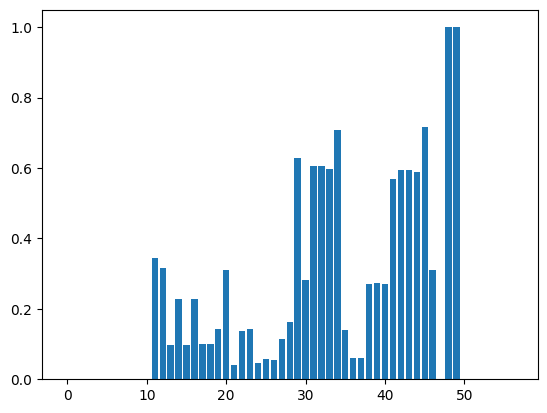

In [7]:
#########################################################################
#             CONVERT TO TABLE AND KEEP ONLY WANTED VARIABLE
#########################################################################

# dataheaders 
dataheaders=sample_and_hold[0,:].tolist()+['Shock_Index', 'PaO2_FiO2']
dataheaders = ['bloc','icustayid','charttime','gender','age','elixhauser','re_admission', 'died_in_hosp', 'died_within_48h_of_out_time','mortality_90d','delay_end_of_record_and_discharge_or_death']+dataheaders
dataheaders = dataheaders+  [ 'median_dose_vaso','max_dose_vaso','input_total','input_4hourly','output_total','output_4hourly','cumulated_balance']

reformat2t=pd.DataFrame(reformat2.copy(),columns = dataheaders) 

# headers I want to keep
dataheaders5 = ['bloc','icustayid','charttime','gender','age','elixhauser','re_admission', 'died_in_hosp', 'died_within_48h_of_out_time','mortality_90d','delay_end_of_record_and_discharge_or_death','SOFA','SIRS',\
    'Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','SpO2','Temp_C','FiO2_1','Potassium','Sodium','Chloride','Glucose',\
    'BUN','Creatinine','Magnesium','Calcium','Ionised_Ca','CO2_mEqL','SGOT','SGPT','Total_bili','Albumin','Hb','WBC_count','Platelets_count','PTT','PT','INR',\
    'Arterial_pH','paO2','paCO2','Arterial_BE','HCO3','Arterial_lactate','mechvent','Shock_Index','PaO2_FiO2',\
    'median_dose_vaso','max_dose_vaso','input_total','input_4hourly','output_total','output_4hourly','cumulated_balance']

ii=np.where(np.isin(reformat2t.columns,dataheaders5))[0] 
reformat3t = reformat2t.iloc[:,ii] 

## SOME DATA MANIP BEFORE IMPUTATION

# CORRECT GENDER
reformat3t.loc[:,'gender']=reformat3t.loc[:,'gender']-1 

# CORRECT AGE > 200 yo
ii=reformat3t.loc[:,'age']>150*365.25
reformat3t.loc[ii,'age']=91.4*365.25

# FIX MECHVENT
ii = np.isnan(reformat3t.loc[:,'mechvent'])
reformat3t.loc[ii,'mechvent']=0
ii = reformat3t.loc[:,'mechvent']>0
reformat3t.loc[ii,'mechvent']=1

# FIX Elixhauser missing values
ii = np.isnan(reformat3t.loc[:,'elixhauser'])
reformat3t.loc[ii,'elixhauser']=np.nanmedian(reformat3t.loc[:,'elixhauser'])  #use the median value / only a few missing data points 


# vasopressors / no NAN
ii=np.isnan(reformat3t.loc[:,'median_dose_vaso'])
reformat3t.loc[ii,'median_dose_vaso']=np.zeros((np.sum(ii)))
ii=np.isnan(reformat3t.loc[:,'max_dose_vaso'])
reformat3t.loc[ii,'max_dose_vaso']=np.zeros((np.sum(ii)))

# check prop of missingness here
miss=np.sum(np.isnan(reformat3t)/reformat3t.shape[0]) 
plt.bar(np.arange(miss.shape[0]), miss)
# plt.show() 

# I fill the values temporarily with zeros, otherwise kNN imp doesnt work
reformat3t['Shock_Index']=np.zeros((reformat3t.shape[0],1))
reformat3t['PaO2_FiO2']=np.zeros((reformat3t.shape[0],1))



In [8]:
#########################################################################
#             HANDLING OF MISSING VALUES  &  CREATE REFORMAT4T
#########################################################################

def fixgaps(x): 
    # FIXGAPS Linearly interpolates gaps in a time series
    # YOUT=FIXGAPS(YIN) linearly interpolates over NaN
    # in the input time series (may be complex), but ignores
    # trailing and leading NaN.
    # R. Pawlowicz 6/Nov/99
    
    y=x
    bd = np.isnan(x)
    gd = np.where(~bd)[0]
    
    bd[0:min(gd)]=0 
    bd[max(gd)+1:]=0 
    
    y[bd] = interp1d(gd,x[gd])(np.where(bd)[0])
                          
    return y 



# K=1
# distance = seuclidean 
# Reference: matlab's knnimpute.m code 
# Reference: https://github.com/ogeidix/kddcup09/blob/master/utilities/knnimpute.m

def knnimpute(data):
    
    K=1 
    userWeights = False 
    useWMean = True  
    # create a copy of data for output
    imputed = data.copy() 
    
    # identify missing vals
    nanVals = np.isnan(data)
    
    # use rows without nans for calculation of nearest neighbors
    noNans = (np.sum(nanVals,axis=1) == 0)    
    dataNoNans = data[noNans,:] 
    
    distances = pdist(np.transpose(dataNoNans),'seuclidean')    
    
    SqF = squareform(distances)
    
    temp = SqF - np.identity(SqF.shape[0])
    
    dists= np.transpose(np.sort(temp))
    
    ndx = np.transpose(np.argsort(temp,kind='stable'))
    
    equalDists = np.vstack([np.diff(dists[1:,:],axis=0)==0.0,np.full(dists.shape[1],False)])
    
    rows= np.where(np.transpose(nanVals))[1]         
    cols = np.where(np.transpose(nanVals))[0] 

    for count in range(rows.size):
        for nearest in range(1,ndx.shape[0]-K+1):
            L = np.where(equalDists[nearest+K-2:,cols[count]]==0)[0][0] 
            dataVals = data[rows[count],ndx[nearest:nearest+K+L,cols[count]]]
            if(useWMean):
                if(~userWeights):
                    weights = 1/dists[1:K+L+1,cols[count]]
                val = wnanmean(dataVals, weights)
            if(~np.isnan(val)):
                imputed[rows[count],cols[count]] = val 
                break 
    return imputed 
                
def wnanmean(x,weights):
    x = x.copy()
    weights = weights.copy() 
    nans = np.isnan(x)
    infs = np.isinf(weights)

    if all(nans): 
        return np.nan
    if any(infs):
        return np.nanmean(x[infs])
    
    x[nans] = 0 
    weights[nans] = 0 
    weights = weights/np.sum(weights)
    return np.dot(np.transpose(weights),x)
    
    



# Do linear interpol where missingness is low (kNN imputation doesnt work if all rows have missing values)

reformat3=reformat3t.values.copy() 
miss=(np.sum(np.isnan(reformat3),axis=0)/reformat3.shape[0]) 

ii=(miss>0) & (miss<0.05) # less than 5% missingness

mechventcol = reformat3t.columns.get_loc('mechvent')

for i in range(10,mechventcol): #correct col by col, otherwise it does it wrongly
    if ii[i]==1: 
        reformat3[:,i]=fixgaps(reformat3[:,i])

        
reformat3t.iloc[:,10:mechventcol]=reformat3[:,10:mechventcol]


# KNN IMPUTATION -  Done on chunks of 10K records.

ref=reformat3[:,10:mechventcol].copy()  #columns of interest


for i in range(0,(reformat3.shape[0]-9999),10000):   #dataset divided in 5K rows chunks (otherwise too large)
    print(i)
    ref[i:i+10000,:]=np.transpose(knnimpute(np.transpose(ref[i:i+10000,:]))) 

ref[-10000:,:]=np.transpose(knnimpute(np.transpose(ref[-10000:,:]))) #the last bit is imputed from the last 10K rows


# I paste the data interpolated, but not the demographics and the treatments
reformat3t.iloc[:,10:mechventcol]=ref   

reformat4t=reformat3t.copy() 
reformat4=reformat4t.values.copy() 



0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000


In [9]:
##########################################################################
#        COMPUTE SOME DERIVED VARIABLES: P/F, Shock Index, SOFA, SIRS...
##########################################################################


# re-compute P/F with no missing values...
p=reformat4t.columns.get_loc('paO2') 
f=reformat4t.columns.get_loc('FiO2_1') 
reformat4t.loc[:,'PaO2_FiO2']=reformat4[:,p]/reformat4[:,f]   

# recompute SHOCK INDEX without NAN and INF
p=reformat4t.columns.get_loc('HR') 
f=reformat4t.columns.get_loc('SysBP') 
a=reformat4t.columns.get_loc('Shock_Index') 
reformat4[:,a]=reformat4[:,p]/reformat4[:,f]  
ii = np.isinf(reformat4[:,a])
reformat4[ii,a]=np.nan 
d=np.nanmean(reformat4[:,a])
ii = np.isnan(reformat4[:,a])
reformat4[ii,a]=d  #replace NaN with average value ~ 0.8
reformat4t.loc[:,'Shock_Index']=reformat4[:,a]
# Reference: https://stackoverflow.com/questions/13733034/equavelent-python-command-for-quantile-in-matlab 
ii=reformat4t['Shock_Index']>=mquantiles(reformat4t['Shock_Index'], 0.999, alphap=0.5, betap=0.5)[0] # replace outliers with 99.9th percentile
reformat4t.loc[ii,'Shock_Index']=mquantiles(reformat4t['Shock_Index'],0.999,alphap=0.5, betap=0.5)[0]


# SOFA - at each timepoint
# need (in this order):  P/F  MV  PLT  TOT_BILI  MAP  NORAD(max)  GCS  CR  UO

s=reformat4t.loc[:,['PaO2_FiO2','Platelets_count','Total_bili','MeanBP','max_dose_vaso','GCS','Creatinine','output_4hourly']].values  
p=np.array([0, 1, 2, 3, 4]) 

s1=np.transpose(np.array([s[:,0]>400, (s[:,0]>=300) & (s[:,0]<400), (s[:,0]>=200) & (s[:,0]<300), (s[:,0]>=100) & (s[:,0]<200), s[:,0]<100 ]))  #count of points for all 6 criteria of sofa
s2=np.transpose(np.array([s[:,1]>150, (s[:,1]>=100) & (s[:,1]<150), (s[:,1]>=50) & (s[:,1]<100), (s[:,1]>=20) & (s[:,1]<50), s[:,1]<20 ]))
s3=np.transpose(np.array([s[:,2]<1.2, (s[:,2]>=1.2) & (s[:,2]<2), (s[:,2]>=2) &(s[:,2]<6), (s[:,2]>=6) & (s[:,2]<12), s[:,2]>12 ]))
s4=np.transpose(np.array([s[:,3]>=70, (s[:,3]<70) & (s[:,3]>=65), s[:,3]<65, (s[:,4]>0) & (s[:,4]<=0.1), s[:,4]>0.1 ]))
s5=np.transpose(np.array([s[:,5]>14, (s[:,5]>12) & (s[:,5]<=14), (s[:,5]>9) & (s[:,5]<=12), (s[:,5]>5) & (s[:,5]<=9), s[:,5]<=5 ]))
s6=np.transpose(np.array([s[:,6]<1.2, (s[:,6]>=1.2) & (s[:,6]<2), (s[:,6]>=2) & (s[:,6]<3.5), ((s[:,6]>=3.5) & (s[:,6]<5)) | (s[:,7]<84), (s[:,6]>5) | (s[:,7]<34) ]))

nrcol=reformat4.shape[1]   # nr of variables in data
reformat4 = np.hstack([reformat4,np.zeros((reformat4.shape[0],7))])

for i in range(0,reformat4.shape[0]):   
    p_s1 = p[s1[i,:]]
    p_s2 = p[s2[i,:]]
    p_s3 = p[s3[i,:]]
    p_s4 = p[s4[i,:]]
    p_s5 = p[s5[i,:]]
    p_s6 = p[s6[i,:]] 
    
    if(p_s1.size==0 or p_s2.size==0 or p_s3.size==0 or p_s4.size==0 or p_s5.size==0 or p_s6.size==0):
        t = 0 
    else : 
        t=max(p_s1)+max(p_s2)+max(p_s3)+max(p_s4)+max(p_s5)+max(p_s6)  #SUM OF ALL 6 CRITERIA        
    
    if(t):
        reformat4[i,nrcol:nrcol+7]=np.array([max(p_s1), max(p_s2), max(p_s3), max(p_s4), max(p_s5), max(p_s6), t])
        
        
# SIRS - at each timepoint |  need: temp HR RR PaCO2 WBC 
s=reformat4t.loc[:,['Temp_C','HR','RR','paCO2','WBC_count']].values  #indices of vars used in SOFA


s1=np.transpose(np.array([(s[:,0]>=38) | (s[:,0]<=36) ],dtype=np.int64))   #count of points for all criteria of SIRS
s2=np.transpose(np.array([s[:,1]>90 ],dtype=np.int64)) 
s3=np.transpose(np.array([(s[:,2]>=20)|(s[:,3]<=32)],dtype=np.int64))
s4=np.transpose(np.array([(s[:,4]>=12)|(s[:,4]<4)],dtype=np.int64))

reformat4 = np.insert(reformat4,nrcol+7,0,axis=1)
reformat4[:,nrcol+7]=np.transpose(s1+s2+s3+s4)

# adds 2 cols for SOFA and SIRS, if necessary
if 'SIRS' not in reformat4t.columns : 
    reformat4t['SOFA'] = 0 
    reformat4t['SIRS'] = 0 
    
# more IO corrections
ii=reformat4t['input_total']<0
reformat4t.loc[ii,'input_total']=0
ii=reformat4t['input_4hourly']<0
reformat4t.loc[ii,'input_4hourly']=0

# records values
reformat4t.loc[:,'SOFA']=reformat4[:,-2]
reformat4t.loc[:,'SIRS']=reformat4[:,-1]



In [10]:
#########################################################################
#                     CREATE FINAL MIMIC_TABLE
#########################################################################


MIMICtable = reformat4t

MIMICtable.to_csv('mimictable.csv',index=False,na_rep='NaN')  

# Save pickle 
with open('step_4_start.pkl', 'wb') as file:
     pickle.dump(MIMICtable,file)